In [63]:
################################################################################
# Import modules
#-------------------------------------------------------------------------------
import numpy as np
import numpy.ma as ma
from astropy.table import Table, QTable
from astropy.io import ascii
import csv


import time


# Import functions from other .py files
from Velocity_Map_Functions import find_phi

from RC_2D_Fit_Functions import Galaxy_Data, \
                                Galaxy_Fitting_iso,\
                                Galaxy_Fitting_NFW, \
                                Galaxy_Fitting_bur, \
                                Hessian_Calculation_Isothermal,\
                                Hessian_Calculation_NFW,\
                                Hessian_Calculation_Burket,\
                                Plotting_Isothermal,\
                                Plotting_NFW,\
                                Plotting_Burkert,\
                                getTidal,\
                                deproject_spaxel,\
                                plot_rot_curve,\
                                plot_diagnostic_panel,\
                                run_MCMC

from Velocity_Map_Functions import loglikelihood_iso_flat,\
                                   loglikelihood_NFW_flat, \
                                   loglikelihood_bur_flat,\
                                   nloglikelihood_iso_flat,\
                                   nloglikelihood_NFW_flat,\
                                   nloglikelihood_bur_flat,\
                                   loglikelihood_iso_flat_constraints,\
                                   loglikelihood_NFW_flat_constraints,\
                                   loglikelihood_bur_flat_constraints

from Velocity_Map_Functions_cython import rot_incl_iso,\
                                          rot_incl_NFW, \
                                          rot_incl_bur

from mapSmoothness_functions import how_smooth

from os import path

import matplotlib.pyplot as plt
from astropy.io import fits
import emcee
################################################################################

In [64]:
################################################################################
# Physics Constants
#-------------------------------------------------------------------------------
c = 3E5 # km * s ^1
h = 1 # reduced hubble constant
H_0 =  100 * h # km * s^-1 * Mpc^-1
q0 = 0.2 # minimum inclination value
################################################################################

In [65]:
################################################################################
# Used files (local)
#-------------------------------------------------------------------------------
MANGA_FOLDER_yifan = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/SDSS/dr17/manga/spectro/'

DRP_FILENAME = MANGA_FOLDER_yifan + 'redux/v3_1_1/drpall-v3_1_1.fits'

VEL_MAP_FOLDER = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/RotationCurve/2D_RC/main/'

#MORPH_FOLDER = '/home/yzh250/Documents/UR_Stuff/Research_UR/SDSS/dr17/manga/morph/'

SMOOTHNESS_MORPH_FOLDER = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/RotationCurve/2D_RC/main/'

smoothness_morph_file = SMOOTHNESS_MORPH_FOLDER + 'cross_table.csv'
################################################################################

In [66]:
################################################################################
# DRP all table
DTable =  Table.read(DRP_FILENAME, format='fits')

#MTable =  Table.read(MORPH_file, format='fits')

DRP_index = {}

for i in range(len(DTable)):
    gal_ID = DTable['plateifu'][i]

    DRP_index[gal_ID] = i
################################################################################

In [67]:
################################################################################
# Get the Mass of stars & redshifts & angular resolution of r50
#-------------------------------------------------------------------------------
m = DTable['nsa_elpetro_mass']
rat = DTable['nsa_elpetro_ba']
phi = DTable['nsa_elpetro_phi']
z = DTable['nsa_z']
r50_ang = DTable['nsa_elpetro_th50_r']
################################################################################

In [68]:
def Galaxy_Data(galaxy_ID, VEL_MAP_FOLDER):
    '''
    PARAMETERS
    ==========

    galaxy_ID : string
        'Plate-IFU'
        
    MANGA_FOLDER : string
        Location of the MaNGA data on the current computer system


    RETURNS
    =======

    physical properties & data of the galaxy

    '''

    plate, IFU = galaxy_ID.split('-')
    '''
    ############################################################################
    # Obtain redshift
    #---------------------------------------------------------------------------
    for i in range(len(DTable2)):
        if DTable2['MaNGA_plate'][i] == int(plate) and DTable2['MaNGA_IFU'][i] == int(IFU):
            redshift = z[i]
            velocity = redshift * c
            distance = (velocity / H_0) * 1E3 #kpc
            scale = 0.5 * (distance) / 206265
    ############################################################################
    '''
    '''
    ############################################################################
    # Obtain inclination
    #---------------------------------------------------------------------------
    incl = 0
    for i in range(len(DTable1)):
        if DTable1['MaNGA_plate'][i] == int(plate) and DTable1['MaNGA_IFU'][i] == int(IFU):
            incl = np.arccos(rat[i])
    ############################################################################
    '''
    '''
    ############################################################################
    # Obtain phi
    #---------------------------------------------------------------------------
    ph = 0
    for i in range(len(DTable1)):
        if DTable1['MaNGA_plate'][i] == int(plate) and DTable1['MaNGA_IFU'][i] == int(IFU):
            ph = phi[i] * np.pi / 180
    ############################################################################
    '''

    ############################################################################
    # Obtaining Data Cubes, Inverse Variances, and Masks
    #---------------------------------------------------------------------------
    
    #bluehive
    cube = fits.open(VEL_MAP_FOLDER + 'manga-' + galaxy_ID + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz')
    #local
    #cube = fits.open(VEL_MAP_FOLDER + plate + '/' + IFU + '/manga-' + galaxy_ID + '-MAPS-HYB10-GAU-MILESHC.fits.gz')

    maps = {}

    # bluehive
    maps['r_band'] = cube['SPX_MFLUX'].data
    maps['Ha_vel'] = cube['EMLINE_GVEL'].data[23]
    maps['Ha_vel_ivar'] = cube['EMLINE_GVEL_IVAR'].data[23]
    maps['Ha_vel_mask'] = cube['EMLINE_GVEL_MASK'].data[23]


    maps['vmasked'] = ma.array(maps['Ha_vel'], mask=maps['Ha_vel_mask'])
    #maps['r_band_masked'] = ma.array(maps['r_band'],mask=maps['Ha_vel_mask'])
    maps['ivar_masked'] = ma.array(maps['Ha_vel_ivar'], mask=maps['Ha_vel_mask'])

    gshape = maps['vmasked'].shape
    ############################################################################

    # Ha flux
    maps['Ha_flux'] = cube['EMLINE_GFLUX'].data[23]
    maps['Ha_flux_ivar'] = cube['EMLINE_GFLUX_IVAR'].data[23]
    maps['Ha_flux_mask'] = cube['EMLINE_GFLUX_MASK'].data[23]
    maps['Ha_flux_masked'] = ma.array(maps['Ha_flux'], mask=maps['Ha_flux_mask'])

    #local
    '''
    maps['r_band'] = cube['SPX_MFLUX'].data
    maps['Ha_vel'] = cube['EMLINE_GVEL'].data[18]
    maps['Ha_vel_ivar'] = cube['EMLINE_GVEL_IVAR'].data[18]
    maps['Ha_vel_mask'] = cube['EMLINE_GVEL_MASK'].data[18]


    maps['vmasked'] = ma.array(maps['Ha_vel'], mask=maps['Ha_vel_mask'])
    #maps['r_band_masked'] = ma.array(maps['r_band'],mask=maps['Ha_vel_mask'])
    maps['ivar_masked'] = ma.array(maps['Ha_vel_ivar'], mask=maps['Ha_vel_mask'])

    gshape = maps['vmasked'].shape
    ############################################################################

    # Ha flux
    maps['Ha_flux'] = cube['EMLINE_GFLUX'].data[18]
    maps['Ha_flux_ivar'] = cube['EMLINE_GFLUX_IVAR'].data[18]
    maps['Ha_flux_mask'] = cube['EMLINE_GFLUX_MASK'].data[18]
    maps['Ha_flux_masked'] = ma.array(maps['Ha_flux'], mask=maps['Ha_flux_mask'])
    '''

    ############################################################################
    # Finding the center
    #---------------------------------------------------------------------------
    '''
    center_guess = np.unravel_index(ma.argmax(maps['r_band_masked']), gshape)
    x_center_guess = center_guess[0]
    y_center_guess = center_guess[1]
    '''
    ############################################################################

    #return r_band, Ha_vel, Ha_vel_ivar, Ha_vel_mask, Ha_flux, Ha_flux_ivar, Ha_flux_mask, vmasked, Ha_flux_masked, ivar_masked, gshape, x_center_guess, y_center_guess
    return maps, gshape#, x_center_guess, y_center_guess

In [134]:
DTable_iso = Table.read('missing_iso.csv',format='ascii.csv')

In [135]:
for i in range(len(DTable_iso)):
    gal_ID = DTable_iso['galaxy_ID'][i]

    data_file = VEL_MAP_FOLDER + 'manga-' + gal_ID + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'

    j = DRP_index[gal_ID]

    redshift = z[j]
    velocity =  redshift* c
    distance = (velocity / H_0) * 1000 #kpc
    scale = 0.5 * distance / 206265

    #incl = np.arccos(rat[j])
    cosi2 = (rat[j]**2 - q0**2)/(1 - q0**2)
    if cosi2 < 0:
        cosi2 = 0

    incl = np.arccos(np.sqrt(cosi2))

    print(incl)

1.0920002958699824
0.5070361231903995
0.5136979145450908
1.3609488809970791
1.344481048513345
1.329399706816655
0.8527673870440202
0.8334126572960772
1.212636032203856
0.9478711855814131
1.37187838461584
1.381700276345362
1.3003435762364237
1.035022490493542
1.4025243482980612
0.8940642382217037
1.1914232298014726
1.5707963267948966
0.8883678453804418
1.2230090526106574


In [136]:
DTable_nfw = Table.read('missing_nfw.csv',format='ascii.csv')

In [137]:
for i in range(len(DTable_nfw)):
    gal_ID = DTable_nfw['galaxy_ID'][i]

    data_file = VEL_MAP_FOLDER + 'manga-' + gal_ID + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'

    j = DRP_index[gal_ID]

    redshift = z[j]
    velocity =  redshift* c
    distance = (velocity / H_0) * 1000 #kpc
    scale = 0.5 * distance / 206265

    #incl = np.arccos(rat[j])
    cosi2 = (rat[j]**2 - q0**2)/(1 - q0**2)
    if cosi2 < 0:
        cosi2 = 0

    incl = np.arccos(np.sqrt(cosi2))

    print(incl)

1.0920002958699824
0.5070361231903995
0.5136979145450908
1.3609488809970791
1.344481048513345
1.329399706816655
0.8527673870440202
0.8334126572960772
1.212636032203856
0.9478711855814131
1.196510861540966
1.37187838461584
1.381700276345362
1.3003435762364237
1.035022490493542
0.8940642382217037
1.1914232298014726
1.5707963267948966
0.8883678453804418
1.2230090526106574


In [138]:
DTable_bur = Table.read('missing_bur.csv',format='ascii.csv')

In [139]:
for i in range(len(DTable_bur)):
    gal_ID = DTable_bur['galaxy_ID'][i]

    data_file = VEL_MAP_FOLDER + 'manga-' + gal_ID + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'

    j = DRP_index[gal_ID]

    redshift = z[j]
    velocity =  redshift* c
    distance = (velocity / H_0) * 1000 #kpc
    scale = 0.5 * distance / 206265

    #incl = np.arccos(rat[j])
    cosi2 = (rat[j]**2 - q0**2)/(1 - q0**2)
    if cosi2 < 0:
        cosi2 = 0

    incl = np.arccos(np.sqrt(cosi2))

    print(incl)

1.0920002958699824
0.5070361231903995
0.5136979145450908
1.3609488809970791
1.344481048513345
0.6281011655655432
0.7598438887227504
1.329399706816655
0.8527673870440202
0.8334126572960772
1.212636032203856
0.9478711855814131
1.37187838461584
1.381700276345362
1.3003435762364237
1.035022490493542
0.8940642382217037
1.1914232298014726
1.5707963267948966
0.8883678453804418
1.2230090526106574


In [122]:
gal_ID = '11752-12705'

data_file = VEL_MAP_FOLDER + 'manga-' + gal_ID + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'

j = DRP_index[gal_ID]

redshift = z[j]
velocity =  redshift* c
distance = (velocity / H_0) * 1000 #kpc
scale = 0.5 * distance / 206265

#incl = np.arccos(rat[j])
cosi2 = (rat[j]**2 - q0**2)/(1 - q0**2)
if cosi2 < 0:
    cosi2 = 0

incl = np.arccos(np.sqrt(cosi2))

print('Incl calculated: ' + str(incl), flush=True)

data_maps, gshape = Galaxy_Data(gal_ID,VEL_MAP_FOLDER)

Incl calculated: 0.7598438887227504


In [123]:
SN_map = data_maps['Ha_flux'] * np.sqrt(data_maps['Ha_flux_ivar'])
Ha_vel_mask = data_maps['Ha_vel_mask'] + (SN_map < 5)

vmasked = ma.array(data_maps['Ha_vel'], mask = Ha_vel_mask)
ivar_masked = ma.array(data_maps['Ha_vel_ivar'], mask = Ha_vel_mask)

r_band_masked = ma.array(data_maps['r_band'],mask=Ha_vel_mask)

center_guess = np.unravel_index(ma.argmax(r_band_masked), gshape)
x_center_guess = center_guess[0]
y_center_guess = center_guess[1]

print('center found',flush=True)

global_max = ma.max(vmasked)

unmasked_data = True

if np.isnan(global_max) or (global_max is ma.masked):
    unmasked_data = False

# center coordinates
center_coord = (x_center_guess, y_center_guess)

if gal_ID in ['8466-12705']:
    center_coord = (37,42)

    ####################################################################
    # Find initial guess for phi
    #-------------------------------------------------------------------

print('Start finding phi', flush=True)

phi_guess = find_phi(center_coord, phi[j], vmasked)

if gal_ID in ['8134-6102']:
    phi_guess += 0.25 * np.pi

elif gal_ID in ['8932-12704', '8252-6103']:
    phi_guess -= 0.25 * np.pi

elif gal_ID in ['8613-12703', '8726-1901', '8615-1901', '8325-9102',
                      '8274-6101', '9027-12705', '9868-12702', '8135-1901',
                      '7815-1901', '8568-1901', '8989-1902', '8458-3701',
                      '9000-1901', '9037-3701', '8456-6101']:
    phi_guess += 0.5 * np.pi

elif gal_ID in ['9864-3702', '8601-1902']:
    phi_guess -= 0.5 * np.pi

elif gal_ID in ['9502-12702']:
    phi_guess += 0.75 * np.pi

elif gal_ID in ['7495-6104']:
    phi_guess -= 0.8 * np.pi

elif gal_ID in ['7495-12704','7815-6103','9029-12705', '8137-3701', '8618-3704', '8323-12701',
                      '8942-3703', '8333-12701', '8615-6103', '9486-3704',
                      '8937-1902', '9095-3704', '8466-1902', '9508-3702',
                      '8727-3703', '8341-12704', '8655-6103']:
    phi_guess += np.pi

elif gal_ID in ['7815-9102']:
    phi_guess -= np.pi

elif gal_ID in ['7443-9101', '7443-3704']:
    phi_guess -= 1.06 * np.pi

elif gal_ID in ['8082-1901', '8078-3703', '8551-1902', '9039-3703',
                      '8624-1902', '8948-12702', '8443-6102', '8259-1901']:
    phi_guess += 1.5 * np.pi

elif gal_ID in ['8241-12705', '8326-6102']:
    phi_guess += 1.75 * np.pi

elif gal_ID in ['7443-6103']:
    phi_guess += 2.3 * np.pi

# phi value
phi_guess = phi_guess % (2 * np.pi)

parameters = [incl, phi_guess, x_center_guess, y_center_guess]

print(parameters)

center found
Start finding phi
1.8153169
(54, 40)
2.827267756484799
[0.7598438887227504, 5.968860410074592, 54, 40]


In [124]:
def log_prior(params):

    log_rhob0,Rb,SigD,Rd,log_rhoh0,Rh,inclination,phi,center_x,center_y,vsys = params

    logP = 0

    rhob_check = -7 < log_rhob0 < 1
    #rhob_check = 0 < log_rhob0 < 10
    Rb_check = 0 < Rb < 5

    SigD_check = 0.1 < SigD < 3000
    Rd_check = 0.1 < Rd < 30

    rhoh_check = -7 < log_rhoh0 < 2
    #rhoh_check = 0 < log_rhoh0 < 100
    Rh_check = 0.01 < Rh < 500

    i_check = 0 < inclination < np.pi*0.436
    phi_check = 0 < phi < 2*np.pi

    x_check = 10 < center_x < 50
    y_check = 10 < center_y < 50

    v_check = -100 < vsys < 100

    if rhob_check and Rb_check and SigD_check and Rd_check and rhoh_check and Rh_check and i_check and phi_check and x_check and y_check and v_check:
        logP = 0

    # setting constraints on the radii
    elif (Rh < Rb) or (Rh < Rd) or (Rd < Rb):
        logP = -np.inf

    else:
        logP = -np.inf

    return logP

def log_prob_iso(params, scale, shape, vdata, ivar, mask):

    lp = log_prior(params)

    logL = loglikelihood_iso_flat_constraints(params, 
                                              scale, 
                                              shape, 
                                              vdata.compressed(), 
                                              ivar.compressed(), 
                                              mask)

    if not np.isfinite(lp) or not np.isfinite(logL):
        return -np.inf 
    else:
        return lp + logL

In [125]:
data_maps, gshape = Galaxy_Data(gal_ID,VEL_MAP_FOLDER)

#data_map = data_maps['vmasked']

SN_map = data_maps['Ha_flux'] * np.sqrt(data_maps['Ha_flux_ivar'])
Ha_vel_mask = data_maps['Ha_vel_mask'] + (SN_map < 5)

vmasked = ma.array(data_maps['Ha_vel'], mask = Ha_vel_mask)
ivar_masked = ma.array(data_maps['Ha_vel_ivar'], mask = Ha_vel_mask)

model_guesses = [-1, 1, 1000, 4, -3, 25]

geo_guesses = parameters + [0]

pos_model = np.random.uniform(low=[-7,0.00001,0.00001,0.0001,-7,0.1], 
                    high=[1,10,3000,30,2,1000], 
                    size=(64,6))

pos_geo = np.array(geo_guesses) + np.random.uniform(np.random.uniform(low=-1e-3*np.ones(len(geo_guesses)), 
                                          high=1e-3*np.ones(len(geo_guesses)), 
                                          size=(64,len(geo_guesses))))

pos_combined = np.column_stack((pos_model,pos_geo))

nwalkers, ndim = pos_combined.shape


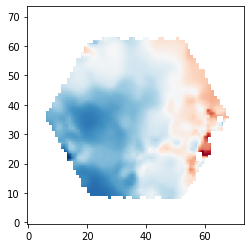

In [126]:
plt.imshow(vmasked,cmap='RdBu_r',origin='lower')

In [108]:
bad_sampler_iso = emcee.EnsembleSampler(nwalkers, 
                                        ndim, 
                                        log_prob_iso, 
                                        args=(scale, 
                                              gshape, 
                                              vmasked, 
                                              ivar_masked, 
                                              Ha_vel_mask))

print('bad sampler iso',flush=True)

bad_sampler_iso.run_mcmc(pos_combined, 10000, progress=True)
bad_samples_iso = bad_sampler_iso.get_chain()
#bad_samples_iso = bad_sampler_iso.get_chain(discard=500)

print('bad samples_iso',flush=True)

ns_iso, nw_iso, nd_iso = bad_samples_iso.shape

#np.save('bad_samples_iso_' + gal_ID + '_comb.npy', bad_samples_iso)

good_walkers_iso = bad_sampler_iso.acceptance_fraction > 0
#np.save('good_walkers_iso_' + gal_ID + '_comb.npy', good_walkers_iso)

good_samples_iso = bad_samples_iso[:,good_walkers_iso,:]

print('ok',flush=True)

# Check if there are walkers being left out
# Make the general cut at 4000 steps
if good_samples_iso.shape != bad_samples_iso.shape:
    print("Inconsistent shapes")
    ns_iso_good, nw_iso_good, nd_iso_good = good_samples_iso[4000:,:,:].shape
    trimmed_flat_good_samples_iso = good_samples_iso[4000:,:,:].reshape(6000*nw_iso_good, nd_iso_good)
    samples_mean_iso = np.mean(trimmed_flat_good_samples_iso, axis=0)
    print(samples_mean_iso)
else:
    trimmed_flat_good_samples_iso = good_samples_iso[4000:,:,:].reshape(6000*nw_iso, nd_iso)
    samples_mean_iso = np.mean(trimmed_flat_good_samples_iso, axis=0)
    print(samples_mean_iso)

# In case the trimming is too much
if not (np.isfinite(samples_mean_iso[-1])):
    if good_samples_iso.shape != bad_samples_iso.shape:
        ns_iso_good, nw_iso_good, nd_iso_good = good_samples_iso.shape
        flat_good_samples_iso = good_samples_iso.reshape(ns_iso_good*nw_iso_good, nd_iso_good)
        samples_mean_iso = np.mean(flat_good_samples_iso, axis=0)
        print(samples_mean_iso)
    else:
        flat_good_samples_iso = good_samples_iso.reshape(ns_iso*nw_iso, nd_iso)
        samples_mean_iso = np.mean(flat_good_samples_iso, axis=0)
        print(samples_mean_iso)

print('MCMC fits generated',flush=True)

fitted_map_mcmc_iso = rot_incl_iso(gshape, scale, np.ndarray.tolist(samples_mean_iso))

print('fitted map generated',flush=True)

mfitted_map_mcmc_iso = ma.array(fitted_map_mcmc_iso, mask=Ha_vel_mask)

print('masked map generated',flush=True)

nd_iso_mcmc = np.sum(~mfitted_map_mcmc_iso.mask)

print('number of data calculated',flush=True)

# chi2_iso = np.nansum((vmasked - vmap_iso) ** 2 * Ha_vel_ivar)
chi2_iso_mcmc = ma.sum(ivar_masked * (vmasked - mfitted_map_mcmc_iso) ** 2)

print('chi2 calculated',flush=True)

# chi2_iso_norm = chi2_iso/(nd_iso - 8)
chi2_iso_norm_mcmc = chi2_iso_mcmc / (nd_iso_mcmc - len(samples_mean_iso))

print('normalized chi2 calculated',flush=True)

bad sampler iso


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/richardzhang/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [05:19<00:00, 31.35it/s]

bad samples_iso
ok
Inconsistent shapes
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
MCMC fits generated
fitted map generated
masked map generated
number of data calculated
chi2 calculated
normalized chi2 calculated



/Users/richardzhang/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/richardzhang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [109]:
bad_samples_iso

array([[[-1.70139145e-01,  9.13762640e+00,  3.17935436e+02, ...,
          1.36387843e+01,  8.40601991e+00,  6.55270879e-01],
        [-3.86108781e+00,  8.35963948e+00,  2.51826179e+03, ...,
          1.33546499e+01,  8.37489624e+00,  1.74046976e-01],
        [-5.84127349e+00,  4.84316933e+00,  1.73926391e+02, ...,
          1.33568851e+01,  8.36190064e+00,  6.86415246e-01],
        ...,
        [-4.01771347e+00,  2.28542201e+00,  1.30754516e+03, ...,
          1.35736059e+01,  8.47896983e+00,  4.77732235e-01],
        [-1.77587731e+00,  6.35244332e+00,  2.07472335e+03, ...,
          1.39502173e+01,  8.10198935e+00,  3.77871172e-01],
        [-3.81500724e+00,  9.94912933e+00,  1.75884201e+03, ...,
          1.38631970e+01,  8.17330122e+00,  2.78719331e-01]],

       [[-1.70139145e-01,  9.13762640e+00,  3.17935436e+02, ...,
          1.36387843e+01,  8.40601991e+00,  6.55270879e-01],
        [-3.86108781e+00,  8.35963948e+00,  2.51826179e+03, ...,
          1.33546499e+01,  8.37489624e

In [110]:
good_walkers_iso = bad_sampler_iso.acceptance_fraction > 0
good_walkers_iso

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


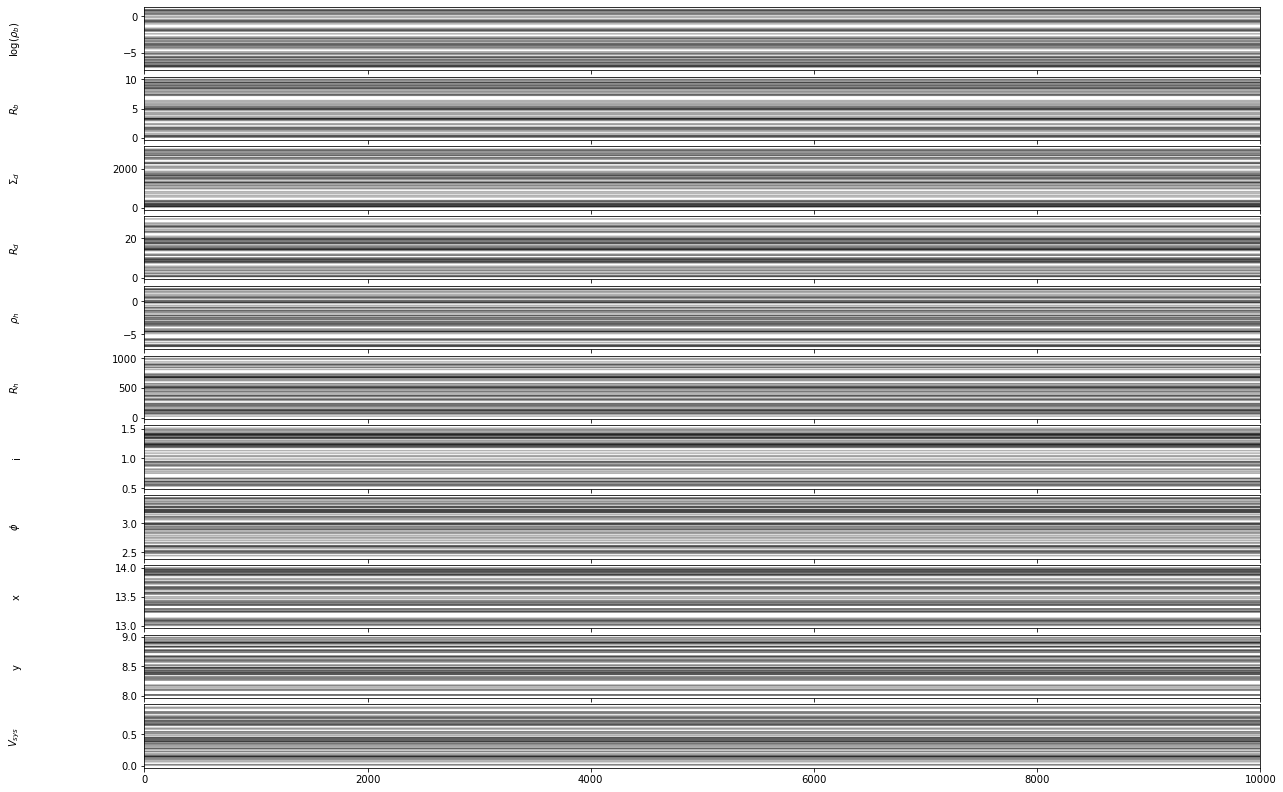

In [111]:
fig_iso, axes_iso = plt.subplots(11,1, 
                                 figsize=(20, 14), 
                                 sharex=True,
                                 gridspec_kw={'hspace':0.1}, 
                                 tight_layout=True)
'''
for i in range(ndim):
    ax = axes_iso[i]
    ax.plot(good_samples_iso[:ns_iso,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_iso), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)
'''  

labels = [r'log($\rho_b$)', 
          r'$R_b$', 
          r'$\Sigma_d$', 
          r'$R_d$',
          r'$\rho_h$', #'log($\rho_h$)',
          r'$R_h$',
          'i',
          r'$\phi$',
          'x',
          'y',
          r'$V_{sys}$']

for i in range(ndim):
    ax = axes_iso[i]
    ax.plot(bad_samples_iso[:ns_iso,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_iso), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)